In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check GPU type
!nvidia-smi

Wed Dec 18 13:16:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Install ultralytics
!pip -q install  ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 49.1 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
DATA_DIR = Path('/content/drive/MyDrive/TomatoDiseaseDetection')

In [ ]:
import gdown
import zipfile
import os
file_id="1PvIXsM_2LYxSzPeEieHPNx11alFpRvks"
url = f'https://drive.google.com/uc?id={file_id}'
zip_file_name = 'images.zip'
gdown.download(url, zip_file_name, quiet=False)
extracted_dir = DATA_DIR / 'images'
os.makedirs(extracted_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1PvIXsM_2LYxSzPeEieHPNx11alFpRvks
From (redirected): https://drive.google.com/uc?id=1PvIXsM_2LYxSzPeEieHPNx11alFpRvks&confirm=t&uuid=4fa6f556-5b59-4ca9-9016-ec5d47bc4850
To: /content/images.zip
100%|██████████| 11.1G/11.1G [01:19<00:00, 140MB/s]


In [ ]:
# Preview data files available
os.listdir(DATA_DIR)

['images']

In [ ]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('/content/drive/MyDrive/TomatoDiseaseDetection/datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'

In [ ]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')

# Add an image_path column
train['image_path'] = [DATA_DIR / Path('images/' + x) for x in train.Image_ID]
# Map str classes to ints (label encoding targets)
class_mapper = {x:y for x,y in zip(sorted(train['class'].unique().tolist()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)
# Preview the head of the train set
train.head()

Image_ID  confidence                class         ymin         xmin  \
0  id_11zffz.jpg         1.0  Tomato_Early_Blight  1824.806363  2312.137866   
1  id_11zffz.jpg         1.0  Tomato_Early_Blight  1627.142285  2420.411721   
2  id_11zffz.jpg         1.0  Tomato_Early_Blight  1967.065318  2338.206424   
3  id_11zffz.jpg         1.0  Tomato_Early_Blight  2296.785571  2694.598986   
4  id_11zffz.jpg         1.0  Tomato_Early_Blight  2779.843437  3392.817431   

          ymax         xmax  \
0  1947.559306  2445.296957   
1  1715.960922  2508.261458   
2  2102.838051  2493.304282   
3  2386.255198  2863.103869   
4  2884.321330  3458.148573   

                                          image_path  class_id  
0  /content/drive/MyDrive/TomatoDiseaseDetection/...         1  
1  /content/drive/MyDrive/TomatoDiseaseDetection/...         1  
2  /content/drive/MyDrive/TomatoDiseaseDetection/...         1  
3  /content/drive/MyDrive/TomatoDiseaseDetection/...         1  
4  /content/drive/MyDrive/TomatoDiseaseDetection/...         1

In [ ]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)
X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]
# Check shapes of training and validation data
X_train.shape, X_val.shape

((12971, 9), (4185, 9))

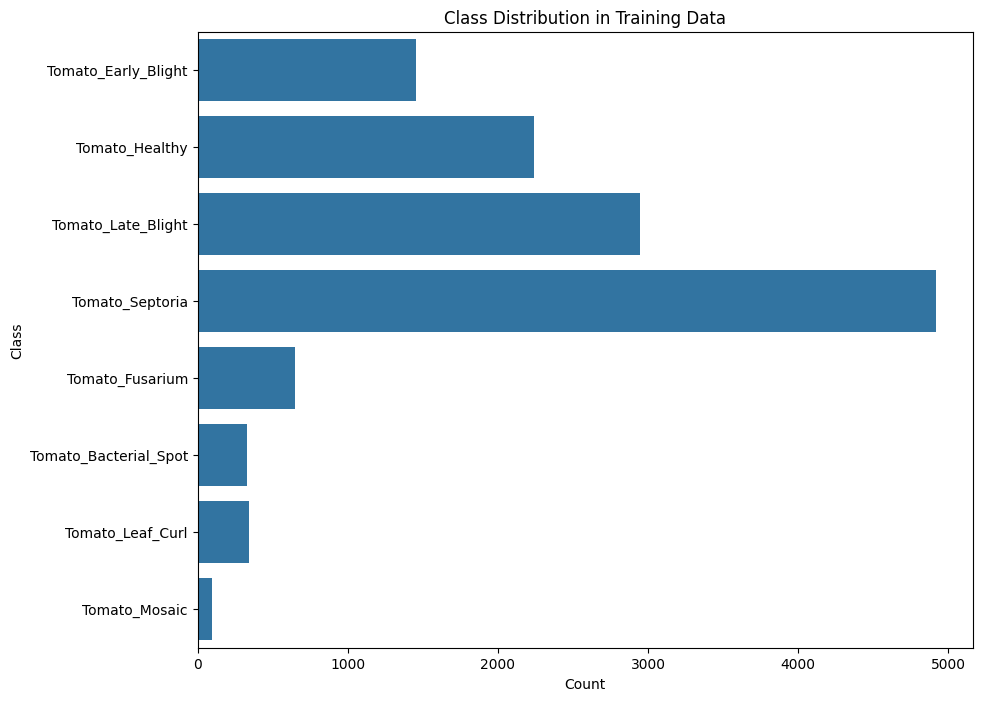

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.countplot(y='class', data=X_train)
plt.title('Class Distribution in Training Data')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

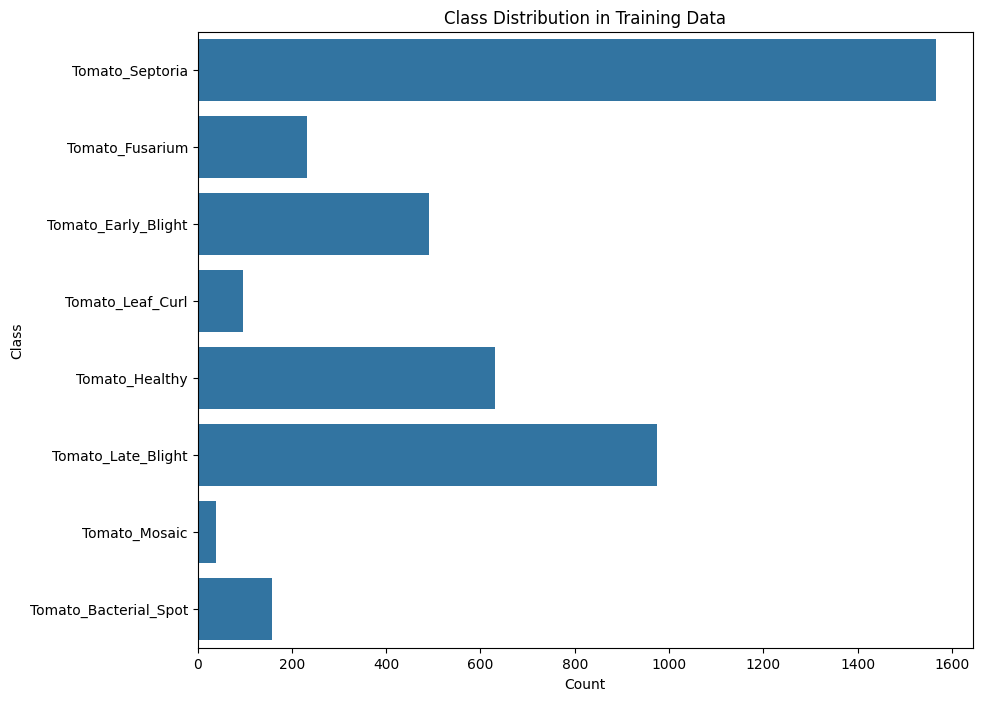

In [ ]:
plt.figure(figsize=(10, 8))
sns.countplot(y='class', data=X_val)
plt.title('Class Distribution in Training Data')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

In [ ]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Tomato_Septoria          0.379076
 Tomato_Late_Blight       0.226968
 Tomato_Healthy           0.172847
 Tomato_Early_Blight      0.112173
 Tomato_Fusarium          0.050112
 Tomato_Leaf_Curl         0.026212
 Tomato_Bacterial_Spot    0.025210
 Tomato_Mosaic            0.007401
 Name: proportion, dtype: float64,
 class
 Tomato_Septoria          0.374194
 Tomato_Late_Blight       0.232736
 Tomato_Healthy           0.150538
 Tomato_Early_Blight      0.117324
 Tomato_Fusarium          0.055436
 Tomato_Bacterial_Spot    0.037515
 Tomato_Leaf_Curl         0.023178
 Tomato_Mosaic            0.009080
 Name: proportion, dtype: float64)

In [ ]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [ ]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

In [ ]:
import multiprocessing
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import pandas as pd

# Function to convert the bboxes to YOLO format
def convert_to_yolo(bbox, width, height):
    ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
    class_id = bbox['class_id']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Top-level function to save annotations for a single image
def save_yolo_annotations_task(task):
    image_path, bboxes, output_dir = task
    try:
        img = np.array(Image.open(str(image_path)))
        height, width, _ = img.shape
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
    with open(label_file, 'w') as f:
        for bbox in bboxes:
            annotation = convert_to_yolo(bbox, width, height)
            f.write(f"{annotation}\n")

# Function to clear output directory
def clear_output_dir(output_dir):
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

# Function to process the dataset and save annotations
def process_dataset(dataframe, output_dir):
    # Clear the output directory to prevent duplicate annotations
    clear_output_dir(output_dir)

    # Group the DataFrame by 'image_path'
    grouped = dataframe.groupby('image_path')
    tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

    # Use multiprocessing Pool to process tasks
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap_unordered(save_yolo_annotations_task, tasks), total=len(tasks)))

In [ ]:
# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

100%|██████████| 321/321 [00:39<00:00,  8.09it/s]


In [ ]:
!sudo rm -r /content/drive/MyDrive/TomatoDiseaseDetection/images

In [ ]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    'train': str(TRAIN_IMAGES_DIR),
    'val': str(VAL_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = '/content/drive/MyDrive/TomatoDiseaseDetection/datasets/dataset/data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/content/drive/MyDrive/TomatoDiseaseDetection/datasets/dataset/images/train',
 'val': '/content/drive/MyDrive/TomatoDiseaseDetection/datasets/dataset/images/val',
 'nc': 8,
 'names': ['Tomato_Bacterial_Spot',
  'Tomato_Early_Blight',
  'Tomato_Fusarium',
  'Tomato_Healthy',
  'Tomato_Late_Blight',
  'Tomato_Leaf_Curl',
  'Tomato_Mosaic',
  'Tomato_Septoria']}

Plotting id_11zffz.jpg with 10 bounding boxes.


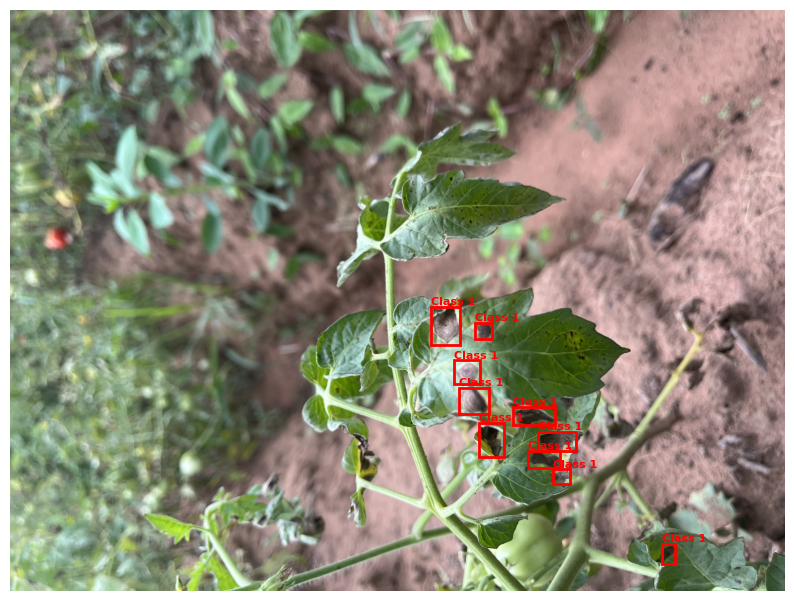

Plotting id_16o914.jpg with 6 bounding boxes.


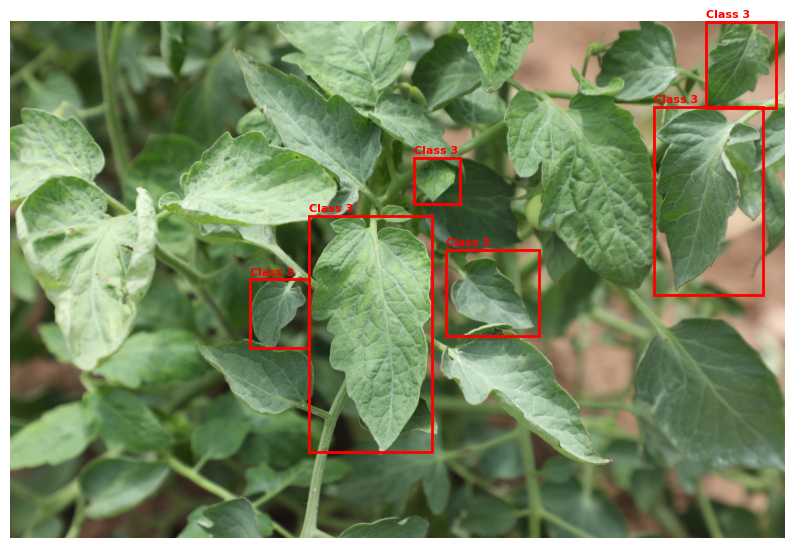

Plotting id_16v82n.jpg with 21 bounding boxes.


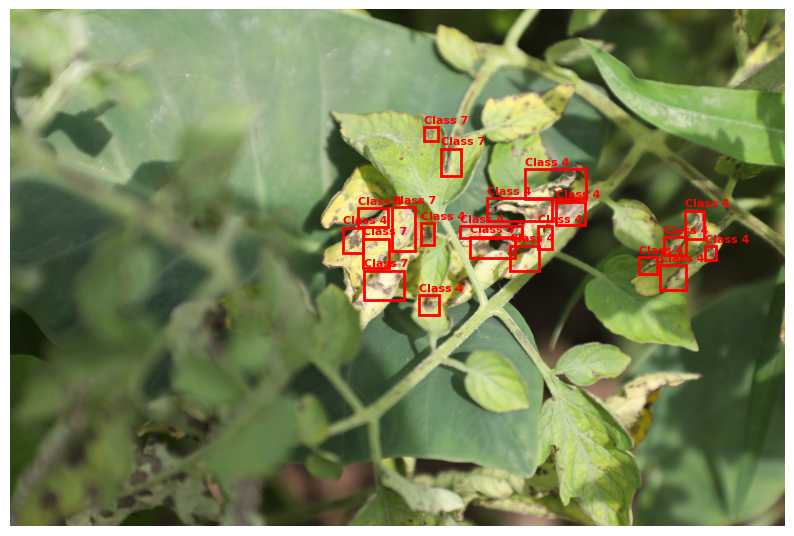

Plotting id_17lyu5.jpg with 5 bounding boxes.


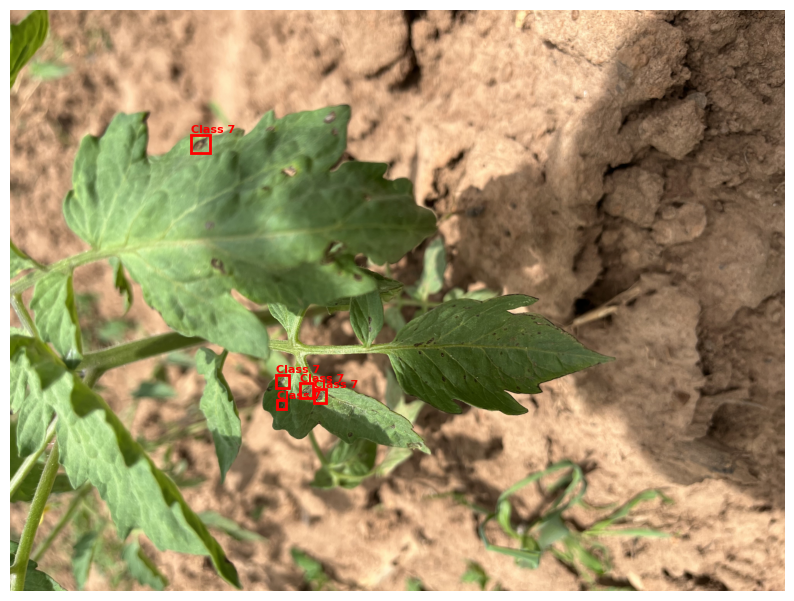

Plotting id_1bh5f5.jpg with 11 bounding boxes.


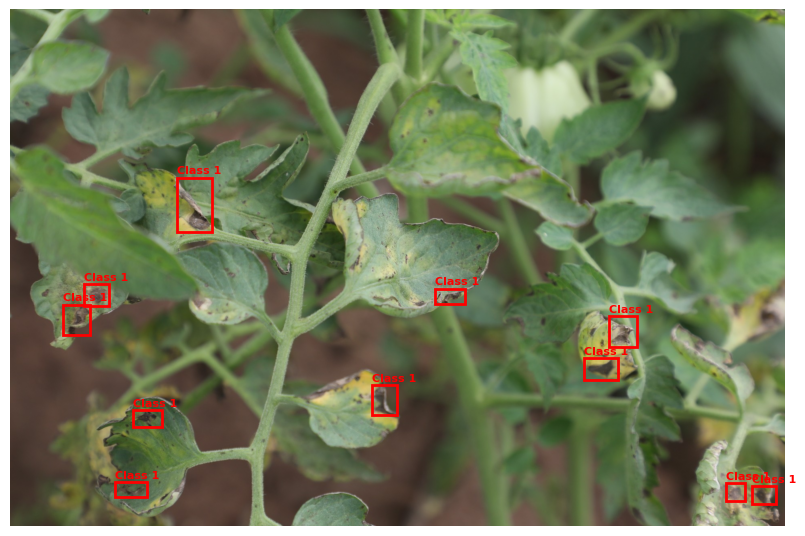

In [ ]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [ ]:
# Load a yolo pretrained model
model = YOLO('yolov10n.pt')

# Fine tune model to our data
model.train(
    data='/content/drive/MyDrive/TomatoDiseaseDetection/datasets/dataset/data.yaml',          # Path to the dataset configuration
    epochs=100,                 # Number of epochs
    imgsz=1024,                # Image size (height, width)
    batch=8,                   # Batch size
    device=0,                  # Device to use (0 for the first GPU)
    )

100%|██████████| 5.59M/5.59M [00:00<00:00, 224MB/s]


Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/drive/MyDrive/TomatoDiseaseDetection/datasets/dataset/data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

100%|██████████| 755k/755k [00:00<00:00, 88.7MB/s]


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 104MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/TomatoDiseaseDetection/datasets/dataset/labels/train.cache... 960 images, 0 backgrounds, 0 corrupt: 100%|██████████| 960/960 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/TomatoDiseaseDetection/datasets/dataset/labels/val.cache... 321 images, 0 backgrounds, 0 corrupt: 100%|██████████| 321/321 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.65G      4.283      8.988      2.957        155       1024: 100%|██████████| 120/120 [09:39<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.57s/it]

                   all        321       4185      0.694     0.0972     0.0606     0.0311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.37G      4.075      7.217      2.751        122       1024: 100%|██████████| 120/120 [01:56<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.66s/it]


                   all        321       4185      0.594      0.122     0.0775     0.0412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.16G      4.017      6.781       2.76        225       1024: 100%|██████████| 120/120 [01:58<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:33<00:00,  1.61s/it]


                   all        321       4185      0.249      0.152     0.0725     0.0339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.59G      3.971      6.382      2.739        129       1024: 100%|██████████| 120/120 [02:01<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.55s/it]


                   all        321       4185      0.495      0.121     0.0968     0.0495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.91G       3.96      6.132      2.735        267       1024: 100%|██████████| 120/120 [02:02<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.51s/it]


                   all        321       4185      0.174      0.179      0.111     0.0575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.08G      3.919      5.753      2.694        127       1024: 100%|██████████| 120/120 [01:56<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.64s/it]


                   all        321       4185      0.359      0.195      0.105     0.0541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.24G      3.827      5.708      2.669        144       1024: 100%|██████████| 120/120 [01:57<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


                   all        321       4185       0.45       0.17      0.143      0.075

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.64G       3.86      5.483      2.701        117       1024: 100%|██████████| 120/120 [01:55<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.65s/it]


                   all        321       4185      0.376      0.213      0.109     0.0547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.26G      3.885      5.415      2.666        240       1024: 100%|██████████| 120/120 [01:56<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.70s/it]


                   all        321       4185      0.399      0.187      0.138      0.071

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.96G      3.796      5.092      2.648        254       1024: 100%|██████████| 120/120 [02:00<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:33<00:00,  1.62s/it]


                   all        321       4185      0.441        0.2      0.148     0.0775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.86G      3.803      5.012      2.652        107       1024: 100%|██████████| 120/120 [01:58<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.55s/it]


                   all        321       4185      0.348      0.228       0.17     0.0842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.84G      3.811      4.964      2.649        143       1024: 100%|██████████| 120/120 [01:57<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.65s/it]

                   all        321       4185      0.444      0.245      0.173     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.61G      3.817      4.978      2.674        280       1024: 100%|██████████| 120/120 [01:54<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.55s/it]


                   all        321       4185      0.339      0.213      0.174     0.0887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.53G       3.78      4.769       2.62        116       1024: 100%|██████████| 120/120 [01:57<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:33<00:00,  1.61s/it]


                   all        321       4185      0.383      0.266      0.202      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.03G      3.795      4.756      2.635        148       1024: 100%|██████████| 120/120 [01:55<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:36<00:00,  1.72s/it]


                   all        321       4185      0.331      0.272        0.2      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.22G      3.744       4.62      2.608        193       1024: 100%|██████████| 120/120 [01:59<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.50s/it]


                   all        321       4185      0.223      0.221      0.187     0.0992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.91G      3.748      4.651      2.622        145       1024: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.52s/it]


                   all        321       4185      0.192       0.27      0.183     0.0927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.29G      3.733      4.499      2.578        216       1024: 100%|██████████| 120/120 [01:55<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.67s/it]


                   all        321       4185      0.452      0.265      0.209      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.93G      3.759      4.495      2.604        205       1024: 100%|██████████| 120/120 [01:53<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:33<00:00,  1.60s/it]


                   all        321       4185      0.219      0.278        0.2      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.95G      3.718      4.457      2.606        159       1024: 100%|██████████| 120/120 [01:56<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.64s/it]


                   all        321       4185      0.339       0.24      0.194     0.0988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.55G      3.675      4.331      2.568        135       1024: 100%|██████████| 120/120 [01:54<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:33<00:00,  1.59s/it]


                   all        321       4185      0.247      0.317      0.226      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.26G      3.739      4.403      2.589        138       1024: 100%|██████████| 120/120 [01:53<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.67s/it]


                   all        321       4185       0.34      0.283      0.196     0.0978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.24G      3.709      4.406       2.59        157       1024: 100%|██████████| 120/120 [01:55<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.69s/it]


                   all        321       4185      0.238      0.275      0.214      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.75G      3.741      4.304      2.583        199       1024: 100%|██████████| 120/120 [01:55<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.52s/it]


                   all        321       4185      0.455      0.291      0.231      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.58G      3.704       4.25      2.577        146       1024: 100%|██████████| 120/120 [01:51<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.70s/it]


                   all        321       4185      0.347      0.292      0.227      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.86G      3.699      4.324      2.588        111       1024: 100%|██████████| 120/120 [01:52<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.69s/it]


                   all        321       4185      0.376      0.295      0.229      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.61G      3.648      4.115      2.543        199       1024: 100%|██████████| 120/120 [01:54<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


                   all        321       4185      0.258      0.283      0.229       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.49G      3.693      4.134      2.577        184       1024: 100%|██████████| 120/120 [01:56<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.62s/it]


                   all        321       4185      0.404      0.292      0.247      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.72G      3.672      4.117      2.565        234       1024: 100%|██████████| 120/120 [01:54<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.67s/it]

                   all        321       4185      0.392      0.288      0.253      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.85G      3.629      4.057      2.553        140       1024: 100%|██████████| 120/120 [02:00<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.65s/it]


                   all        321       4185      0.469      0.259      0.243      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.37G      3.585      4.027      2.531        178       1024: 100%|██████████| 120/120 [01:59<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.70s/it]

                   all        321       4185      0.274      0.303      0.246      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.38G      3.629      4.028      2.548        187       1024: 100%|██████████| 120/120 [01:58<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.63s/it]


                   all        321       4185      0.339      0.322      0.258      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.44G      3.609      3.917      2.547        139       1024: 100%|██████████| 120/120 [02:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.68s/it]


                   all        321       4185      0.327      0.307      0.256      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.08G      3.662      4.019      2.527        169       1024: 100%|██████████| 120/120 [02:07<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:33<00:00,  1.60s/it]

                   all        321       4185      0.274      0.301      0.237      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.88G      3.624      3.926       2.52        242       1024: 100%|██████████| 120/120 [02:09<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:33<00:00,  1.61s/it]


                   all        321       4185      0.304      0.308      0.276      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.96G      3.594      3.859      2.529        232       1024: 100%|██████████| 120/120 [02:01<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


                   all        321       4185      0.277      0.341      0.262      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.74G      3.633      3.865      2.526         92       1024: 100%|██████████| 120/120 [01:52<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.68s/it]


                   all        321       4185      0.268      0.356       0.27      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.47G      3.595      3.777      2.534        191       1024: 100%|██████████| 120/120 [01:55<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:33<00:00,  1.61s/it]


                   all        321       4185      0.342      0.322      0.255      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.51G       3.62      3.874      2.533        175       1024: 100%|██████████| 120/120 [01:48<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.68s/it]

                   all        321       4185      0.299      0.345      0.255      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.72G      3.534      3.702      2.481        183       1024: 100%|██████████| 120/120 [01:51<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.68s/it]

                   all        321       4185       0.33      0.355       0.28      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.73G      3.546      3.753      2.524        167       1024: 100%|██████████| 120/120 [01:50<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.65s/it]


                   all        321       4185      0.289      0.348      0.278       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.09G      3.531      3.656      2.469        153       1024: 100%|██████████| 120/120 [01:53<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.64s/it]


                   all        321       4185      0.302      0.345      0.277      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.79G      3.585      3.688      2.497        151       1024: 100%|██████████| 120/120 [01:54<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


                   all        321       4185      0.273      0.349      0.275      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.71G      3.536       3.69      2.521        181       1024: 100%|██████████| 120/120 [01:54<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:34<00:00,  1.63s/it]


                   all        321       4185      0.222      0.363      0.257      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.34G      3.483      3.559      2.473        202       1024: 100%|██████████| 120/120 [01:55<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.68s/it]


                   all        321       4185      0.287      0.346      0.262      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.44G      3.501      3.527      2.484        172       1024: 100%|██████████| 120/120 [01:57<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:35<00:00,  1.67s/it]


                   all        321       4185      0.333      0.355      0.277      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       4.7G      3.569      3.595      2.484        105       1024: 100%|██████████| 120/120 [01:53<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


                   all        321       4185      0.333      0.367      0.309      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.76G      3.537      3.562      2.508        128       1024: 100%|██████████| 120/120 [01:49<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


                   all        321       4185      0.347      0.362      0.303      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.41G      3.508       3.49       2.47        273       1024: 100%|██████████| 120/120 [01:44<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.38s/it]


                   all        321       4185      0.339      0.388      0.308      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.24G      3.483      3.416      2.427        100       1024: 100%|██████████| 120/120 [01:43<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.46s/it]


                   all        321       4185      0.437      0.334      0.301      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.14G      3.531      3.508      2.453        317       1024: 100%|██████████| 120/120 [01:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.48s/it]

                   all        321       4185      0.303      0.368      0.307      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       4.5G      3.507      3.482      2.469        165       1024: 100%|██████████| 120/120 [01:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.50s/it]


                   all        321       4185      0.352      0.398       0.31       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.72G      3.492      3.363      2.445        226       1024: 100%|██████████| 120/120 [01:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.44s/it]


                   all        321       4185      0.354      0.374      0.306      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.85G      3.473      3.356      2.461        154       1024: 100%|██████████| 120/120 [01:44<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.47s/it]


                   all        321       4185      0.368      0.391      0.316      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.75G      3.488      3.429      2.458        143       1024: 100%|██████████| 120/120 [01:46<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.43s/it]


                   all        321       4185      0.359      0.384      0.311      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.87G      3.473      3.337      2.439         92       1024: 100%|██████████| 120/120 [01:47<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


                   all        321       4185      0.392      0.399      0.332      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.13G      3.442      3.303      2.433        140       1024: 100%|██████████| 120/120 [01:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]

                   all        321       4185      0.386      0.371      0.317      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.79G      3.448      3.334      2.436        157       1024: 100%|██████████| 120/120 [01:49<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


                   all        321       4185      0.384      0.385      0.329       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.08G      3.441      3.222      2.414        254       1024: 100%|██████████| 120/120 [01:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


                   all        321       4185      0.444      0.383       0.33      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.39G      3.398      3.163      2.403        240       1024: 100%|██████████| 120/120 [01:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


                   all        321       4185      0.367      0.413      0.335       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.47G      3.411      3.209      2.422        169       1024: 100%|██████████| 120/120 [01:44<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.45s/it]

                   all        321       4185      0.404      0.419      0.348      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.78G      3.444      3.161      2.419        207       1024: 100%|██████████| 120/120 [01:47<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


                   all        321       4185      0.375      0.386      0.319      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.76G      3.425      3.201      2.431        117       1024: 100%|██████████| 120/120 [01:49<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


                   all        321       4185      0.344      0.374      0.316      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       4.7G       3.37      3.101      2.394        175       1024: 100%|██████████| 120/120 [01:47<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


                   all        321       4185       0.39      0.422       0.36      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.22G      3.416       3.14      2.428        101       1024: 100%|██████████| 120/120 [01:48<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


                   all        321       4185      0.383      0.424      0.347       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.04G      3.379      3.087      2.411        234       1024: 100%|██████████| 120/120 [01:49<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


                   all        321       4185      0.369      0.424      0.359      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.58G      3.375      3.095       2.39        241       1024: 100%|██████████| 120/120 [01:47<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


                   all        321       4185      0.355      0.425      0.338      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       4.7G      3.377       3.04      2.391        168       1024: 100%|██████████| 120/120 [01:44<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.50s/it]


                   all        321       4185      0.443      0.428      0.367      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.44G      3.398      3.073      2.395        173       1024: 100%|██████████| 120/120 [01:45<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


                   all        321       4185      0.421      0.431      0.375      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.21G      3.325      2.957      2.358        135       1024: 100%|██████████| 120/120 [01:44<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]

                   all        321       4185      0.408      0.432      0.366      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.72G      3.367      2.978      2.395        223       1024: 100%|██████████| 120/120 [01:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


                   all        321       4185      0.391      0.431      0.357      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.05G      3.337      2.974      2.368        203       1024: 100%|██████████| 120/120 [01:45<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


                   all        321       4185      0.427      0.398      0.371      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.53G      3.324      2.957      2.362        186       1024: 100%|██████████| 120/120 [01:48<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


                   all        321       4185       0.41      0.427      0.388      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.45G      3.359      2.973      2.375        239       1024: 100%|██████████| 120/120 [01:47<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


                   all        321       4185      0.387      0.437      0.357      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.08G      3.355      2.948      2.359        131       1024: 100%|██████████| 120/120 [01:47<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


                   all        321       4185       0.41      0.428      0.373      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.87G      3.329        2.9      2.351        205       1024: 100%|██████████| 120/120 [01:49<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


                   all        321       4185      0.416      0.432      0.368      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.08G      3.349      2.942      2.378        237       1024: 100%|██████████| 120/120 [01:48<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.47s/it]


                   all        321       4185      0.406       0.44      0.367      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.07G      3.334      2.915      2.356        218       1024: 100%|██████████| 120/120 [01:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.47s/it]


                   all        321       4185      0.418      0.446      0.371      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.69G      3.293      2.865      2.344        202       1024: 100%|██████████| 120/120 [01:40<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.49s/it]


                   all        321       4185      0.428      0.439      0.376        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.38G      3.291      2.831      2.343        140       1024: 100%|██████████| 120/120 [01:39<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.44s/it]

                   all        321       4185      0.448      0.452      0.388      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.51G      3.273      2.773      2.356        123       1024: 100%|██████████| 120/120 [01:39<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.39s/it]


                   all        321       4185      0.435      0.461      0.388        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       4.6G      3.264      2.829       2.35        159       1024: 100%|██████████| 120/120 [01:40<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


                   all        321       4185      0.424      0.455      0.371      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.09G      3.261      2.765      2.337        198       1024: 100%|██████████| 120/120 [01:40<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]

                   all        321       4185      0.434      0.453      0.386      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.85G      3.262      2.756      2.339        207       1024: 100%|██████████| 120/120 [01:44<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.49s/it]


                   all        321       4185      0.431      0.454      0.397      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.81G      3.239      2.706      2.337        212       1024: 100%|██████████| 120/120 [01:44<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.50s/it]


                   all        321       4185      0.419       0.46      0.392      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.43G      3.273      2.807      2.357        226       1024: 100%|██████████| 120/120 [01:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.48s/it]


                   all        321       4185      0.408      0.465      0.392      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.16G      3.251      2.729      2.327        193       1024: 100%|██████████| 120/120 [01:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


                   all        321       4185      0.439      0.446      0.384      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.89G      3.231      2.696      2.325        171       1024: 100%|██████████| 120/120 [01:44<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


                   all        321       4185      0.453      0.459      0.403      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.08G      3.234      2.662      2.302        160       1024: 100%|██████████| 120/120 [01:51<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


                   all        321       4185      0.453      0.465      0.399      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.48G      3.204      2.651      2.316        165       1024: 100%|██████████| 120/120 [01:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


                   all        321       4185       0.45      0.466      0.393      0.207
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.12G      3.209      2.651      2.328        127       1024: 100%|██████████| 120/120 [01:43<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


                   all        321       4185      0.412      0.449      0.381      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.48G      3.175      2.547       2.33        122       1024: 100%|██████████| 120/120 [01:38<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


                   all        321       4185      0.426       0.47      0.403      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.27G      3.148      2.508        2.3        101       1024: 100%|██████████| 120/120 [01:39<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


                   all        321       4185      0.432      0.464        0.4      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.09G      3.157        2.5      2.309         80       1024: 100%|██████████| 120/120 [01:38<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.51s/it]

                   all        321       4185      0.439      0.462        0.4       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.35G      3.144      2.492      2.314         69       1024: 100%|██████████| 120/120 [01:39<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


                   all        321       4185      0.429      0.461      0.389      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.13G      3.116      2.444      2.313        106       1024: 100%|██████████| 120/120 [01:38<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.47s/it]


                   all        321       4185      0.454      0.449      0.403      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.39G      3.114      2.443      2.303         74       1024: 100%|██████████| 120/120 [01:38<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


                   all        321       4185      0.443      0.461      0.407      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.26G      3.118      2.432        2.3        105       1024: 100%|██████████| 120/120 [01:39<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


                   all        321       4185       0.46      0.455      0.402      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.24G      3.081       2.39      2.301         88       1024: 100%|██████████| 120/120 [01:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]

                   all        321       4185      0.446      0.456      0.398      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.17G       3.11      2.361      2.294        120       1024: 100%|██████████| 120/120 [01:38<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.52s/it]

                   all        321       4185      0.453      0.453      0.401      0.211



100 epochs completed in 4.150 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2,697,536 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:33<00:00,  1.58s/it]


                   all        321       4185      0.443      0.461      0.407      0.213
 Tomato_Bacterial_Spot         18        157      0.375      0.382      0.316       0.14
   Tomato_Early_Blight         61        491      0.389      0.517      0.415      0.205
       Tomato_Fusarium         22        232      0.454      0.398      0.384      0.162
        Tomato_Healthy         63        630      0.568      0.838      0.765      0.525
    Tomato_Late_Blight        105        974      0.375      0.335      0.243     0.0999
      Tomato_Leaf_Curl         19         97      0.334      0.409      0.297      0.152
         Tomato_Mosaic          8         38      0.663      0.395      0.503      0.299
       Tomato_Septoria        118       1566      0.383      0.411       0.33      0.122
Speed: 0.6ms preprocess, 8.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dfee5486bf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [ ]:
model.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
import shutil
source_folder = '/content/runs'
destination_folder = '/content/drive/MyDrive/TomatoDiseaseDetection/runs'
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/TomatoDiseaseDetection/runs'